## CNN 1b

### Load Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Datensatz laden und DatenLoader

In [2]:
data_path = 'data/embedded_padded'

BATCH_SIZE = 32

train_dataset = torch.load(data_path + '/train.pt')
test_dataset = torch.load(data_path + '/test.pt')
val_dataset = torch.load(data_path + '/val.pt')

# DataLoader vorbereiten


def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])  
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.float32).unsqueeze(1)  
    return input_ids, labels

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

/var/folders/l7/061cw0t95vz1myntpf9bj9540000gn/T/ipykernel_32265/1764171208.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load(data_path + '/trai


### CNN-Modell definieren


In [3]:
class HumorCNN(nn.Module):
    def __init__(self, embedding_dim=100):
        super(HumorCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 50, (3, embedding_dim))
        self.conv2 = nn.Conv2d(1, 50, (4, embedding_dim))
        self.conv3 = nn.Conv2d(1, 50, (5, embedding_dim))

        self.bn1 = nn.BatchNorm1d(50)
        self.bn2 = nn.BatchNorm1d(50)
        self.bn3 = nn.BatchNorm1d(50)

        self.fc = nn.Linear(150, 1)

        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = x.unsqueeze(1)  

        x1 = F.relu(self.bn1(self.conv1(x).squeeze(3)))
        x2 = F.relu(self.bn2(self.conv2(x).squeeze(3)))
        x3 = F.relu(self.bn3(self.conv3(x).squeeze(3)))
        
        x1 = F.max_pool1d(x1, x1.size(2)).squeeze(2)
        x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)
        x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)

        x = torch.cat((x1, x2, x3), 1)
        
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)



### Training des Modells


In [4]:
# Automatische Geräteauswahl (Apple MPS, CUDA, CPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")  
elif torch.cuda.is_available():
    device = torch.device("cuda")  
else:
    device = torch.device("cpu")  

model = HumorCNN().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)  

epochs = 10  # Nur 10 Epochen
best_val_loss = float('inf')
best_test_accuracy = 0
patience = 3
counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)

    # ========================
    # Validierung
    # ========================
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)

    # ========================
    # Evaluierung mit Testdaten
    # ========================
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            predictions = (outputs > 0.5).float()
            test_preds.extend(predictions.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')
    
    # ========================
    # Lernraten-Anpassung
    # ========================
    scheduler.step(avg_val_loss)

    # ========================
    # Bestes Modell speichern
    # ========================
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        torch.save(model.state_dict(), "best_model.pth")
        print("🚀 Bestes Modell gespeichert mit Test-Accuracy:", test_accuracy)

    # ========================
    # Early Stopping
    # ========================
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping ausgelöst!")
            break


/Users/michellegoppinger/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Users/michellegoppinger/Documents/Dokumente – Laptop von Michelle/Uni/Master/ANLP/CA2/ANLP_WS24_CA2/HumorDataset.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  item = {'input_ids': torch.tensor(self.data[idx], dtype=torch.float)}


Epoch 1/10, Train Loss: 1.0778, Val Loss: 0.6097, Test Acc: 0.6734, Test F1: 0.6567
🚀 Bestes Modell gespeichert mit Test-Accuracy: 0.6734279918864098
Epoch 2/10, Train Loss: 0.7699, Val Loss: 0.5868, Test Acc: 0.7069, Test F1: 0.7175
🚀 Bestes Modell gespeichert mit Test-Accuracy: 0.7068965517241379
Epoch 3/10, Train Loss: 0.6620, Val Loss: 0.5702, Test Acc: 0.7373, Test F1: 0.7566
🚀 Bestes Modell gespeichert mit Test-Accuracy: 0.7373225152129818
Epoch 4/10, Train Loss: 0.6219, Val Loss: 0.5475, Test Acc: 0.7556, Test F1: 0.7692
🚀 Bestes Modell gespeichert mit Test-Accuracy: 0.755578093306288
Epoch 5/10, Train Loss: 0.6035, Val Loss: 0.5171, Test Acc: 0.7769, Test F1: 0.7804
🚀 Bestes Modell gespeichert mit Test-Accuracy: 0.7768762677484787
Epoch 6/10, Train Loss: 0.5956, Val Loss: 0.5026, Test Acc: 0.7926, Test F1: 0.8111
🚀 Bestes Modell gespeichert mit Test-Accuracy: 0.7925963488843814
Epoch 7/10, Train Loss: 0.5601, Val Loss: 0.4781, Test Acc: 0.8119, Test F1: 0.7978
🚀 Bestes Modell g


### Finale Evaluierung & Confusion Matrix



/var/folders/l7/061cw0t95vz1myntpf9bj9540000gn/T/ipykernel_32265/3375079771.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.

🚀 Finale Test Accuracy: 0.8813
🚀 Finale Test F1 Score: 0.8741


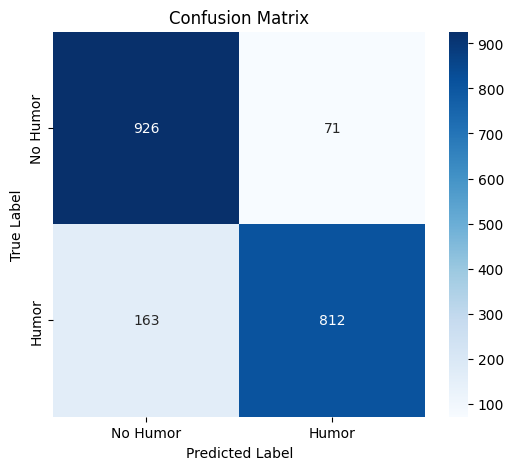

In [5]:
model.load_state_dict(torch.load("best_model.pth"))  
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():  
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        predictions = (outputs > 0.5).float()
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = [int(p[0]) for p in all_preds]
all_labels = [int(l[0]) for l in all_labels]

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f'🚀 Finale Test Accuracy: {accuracy:.4f}')
print(f'🚀 Finale Test F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['No Humor', 'Humor'], yticklabels=['No Humor', 'Humor'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()